In [8]:
import torch
import matplotlib.pyplot as plt

In [13]:
class Rotary(torch.nn.Module):
    def __init__(self, dim, base=10000):
        super().__init__()
        self.inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.seq_len_cached = None
        self.cos_cached = None
        self.sin_cached = None

    def forward(self, x):
        seq_len = x.shape[1]
        if seq_len != self.seq_len_cached:
            self.seq_len_cached = seq_len
            t = torch.arange(seq_len, device=x.device).type_as(self.inv_freq)
            freqs = torch.outer(t, self.inv_freq).to(x.device)
            self.cos_cached = freqs.cos().bfloat16()
            self.sin_cached = freqs.sin().bfloat16()
        return self.cos_cached[None, :, None, :], self.sin_cached[None, :, None, :]

def apply_rotary_emb(x, cos, sin):
    assert x.ndim == 4 # multihead attention
    d = x.shape[3]//2
    x1 = x[..., :d]
    x2 = x[..., d:]
    y1 = x1 * cos + x2 * sin
    y2 = x1 * (-sin) + x2 * cos
    return torch.cat([y1, y2], 3).type_as(x)

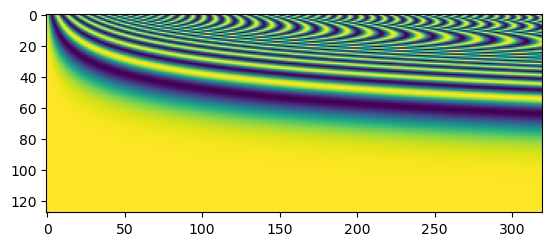

In [59]:
B, T, n_head, head_dim = 16, 320, 8, 256
rotary = Rotary(head_dim)
q = torch.randn(B, T, n_head, head_dim)
cos, sin = rotary(q)
plt.imshow(cos.squeeze().float().T)

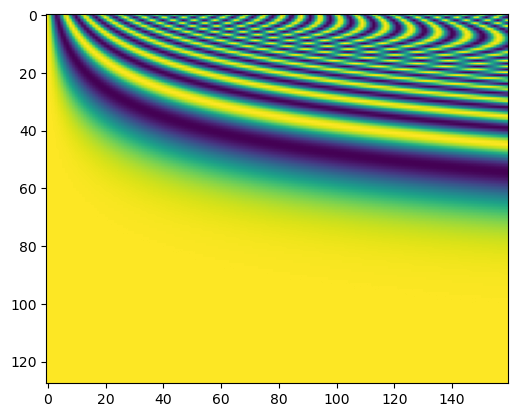

In [61]:
B, T, n_head, head_dim = 16, 160, 8, 256
rotary = Rotary(head_dim)
q = torch.randn(B, T, n_head, head_dim)
cos_t, sin_t = rotary(q)
plt.imshow(cos_t.squeeze().float().T)

In [71]:
torch.allclose(cos.squeeze()[:160], cos_t.squeeze())

True

In [72]:
class Rotary(torch.nn.Module):
    def __init__(self, dim, base=10000, max_seq_len=320):
        super().__init__()
        self.inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.seq_len_cached = max_seq_len
        t = torch.arange(max_seq_len).type_as(self.inv_freq)
        freqs = torch.outer(t, self.inv_freq)
        self.cos_cached = freqs.cos().bfloat16()
        self.sin_cached = freqs.sin().bfloat16()

    def forward(self, x):
        seq_len = x.shape[1]
        cos = self.cos_cached[:seq_len]
        sin = self.sin_cached[:seq_len]
        return cos[None, :, None, :], sin[None, :, None, :]

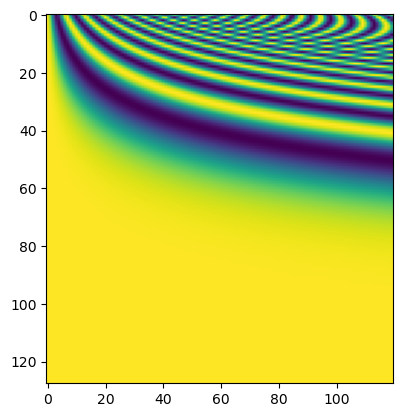

In [76]:
B, T, n_head, head_dim = 16, 120, 8, 256
rotary = Rotary(head_dim)
q = torch.randn(B, T, n_head, head_dim)
cos, sin = rotary(q)
plt.imshow(cos.squeeze().float().T)